In [1]:
import numpy as np
import pandas as pd 

from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from keras import regularizers

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

dataTrait = df.drop(columns=["OsID", "Class"])# exclude OSID and Class Column
print("Summary of dataTrait:\n",dataTrait.describe())


X = dataTrait.drop(['Trait'], axis=1) # exclude log_2FoldChange and trait columns
Y = dataTrait['Trait']

print("Shape of X:\n",X.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
print("Summary of X:\n",X.describe())
print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X = X.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)


Summary of dataTrait:
        log_2FoldChange            ET  CoExpression           PCC   
count     41986.000000  41986.000000  41986.000000  41986.000000  \
mean         -0.040210      1.386724      0.988687     -0.365709   
std           0.389447      0.796948      0.105762      0.462418   
min          -1.000000      0.000000      0.000000     -1.000000   
25%          -0.251534      1.000000      1.000000     -0.750074   
50%           0.030675      2.000000      1.000000     -0.449089   
75%           0.251534      2.000000      1.000000     -0.055126   
max           1.000000      2.000000      1.000000      1.000000   

                PPI  Root10DaysSeedling  Root14DaysSeedling   
count  41986.000000        41986.000000        41986.000000  \
mean       0.909779           -0.526973           -0.646217   
std        0.286501            0.496871            0.393963   
min        0.000000           -1.000000           -1.000000   
25%        1.000000           -0.906841          

In [4]:
# prepare target data
def prepare_targets(y_train, y_test):
	ohe = OneHotEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = ohe.fit_transform(y_train)
	y_test_enc = ohe.transform(y_test)
	
	y_train_enc = y_train_enc.toarray()
	y_test_enc = y_test_enc.toarray()

	return y_train_enc, y_test_enc

In [5]:
# define baseline model (MLP)
def baseline_model():

    model = Sequential()
    model.add(Dense(60, input_dim=20,bias_initializer='normal', activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(6,kernel_initializer='normal', activation='softmax')) #softmax for multi-class classification, num_classes = 6

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [6]:
def accuracy(confusion_matrix):
   diagonal_sum = confusion_matrix.trace()
   sum_of_all_elements = confusion_matrix.sum()
   return diagonal_sum / sum_of_all_elements

In [7]:
def draw_confusion_matrix(cm):
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d", center=0, cmap='autumn') 
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [8]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

In [9]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the training, validation and test accuracy and loss of each fold
train_accuracy = []
train_loss = []
val_accuracy = []
val_loss = []
test_accuracy = []
models = []
hist = []

# Loop over the folds
for fold, (train_index, val_index) in enumerate(cv_method.split(X_train, y_train)):
    print("Fold:", fold+1)

    # Split the data into train and validation sets using the current fold index
    X_train_fold  = X_train[train_index]
    y_train_fold  = y_train[train_index]
    X_val_fold = X_train[val_index]
    y_val_fold = y_train[val_index]

    # Prepare the target data
    y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

    # Build the model
    model = baseline_model()

    # Fit the model to the training data for the current fold
    history = model.fit(X_train_fold,y_train_fold_enc, epochs=120, batch_size=5, verbose=1, validation_split = 0.33)
    
    # Evaluate the model on the validation data for the current fold
    val_scores = model.evaluate(X_val_fold, y_val_fold_enc, verbose=0)
    val_accuracy.append(val_scores[1])
    val_loss.append(val_scores[0])

    # Evaluate the model on the test data for the current fold
    test_scores = model.evaluate(X_test, y_test_enc, verbose=0)
    test_accuracy.append(test_scores[1])

    # add the model to the list of models
    models.append(model)
    hist.append(history)

    # store the training accuracy and loss for each fold
    train_accuracy.append(history.history['accuracy'])
    train_loss.append(history.history['loss'])
      
    # Print the test and validation accuracy and loss for the current fold
    print("Validation Accuracy:", val_scores[1])
    print("Validation Loss:", val_scores[0])
    print("Test Accuracy:", test_scores[1])
    print("Test Loss:", test_scores[0])

        
# Calculate the average test and validation accuracy and loss across all folds
avg_test_acc = sum(test_accuracy) / len(test_accuracy)
avg_val_acc = sum(val_accuracy) / len(val_accuracy)
avg_val_loss = sum(val_loss) / len(val_loss)

# Print the average validation and test accuracy and loss
print("Average Validation Accuracy:", avg_val_acc)
print("Average Validation Loss:",avg_val_loss)
print("Average Test Accuracy:", avg_test_acc)

Fold: 1
Epoch 1/120
1885/1885 [==============================] - 11s 4ms/step - loss: 1.3919 - accuracy: 0.4061 - val_loss: 1.2303 - val_accuracy: 0.4858
Epoch 2/120
1885/1885 [==============================] - 4s 2ms/step - loss: 1.1888 - accuracy: 0.4873 - val_loss: 1.1621 - val_accuracy: 0.5054
Epoch 3/120
1885/1885 [==============================] - 4s 2ms/step - loss: 1.1162 - accuracy: 0.4874 - val_loss: 1.1257 - val_accuracy: 0.5002
Epoch 4/120
1885/1885 [==============================] - 4s 2ms/step - loss: 1.0633 - accuracy: 0.5107 - val_loss: 1.0598 - val_accuracy: 0.5114
Epoch 5/120
1885/1885 [==============================] - 5s 3ms/step - loss: 1.0224 - accuracy: 0.5143 - val_loss: 1.0177 - val_accuracy: 0.5112
Epoch 6/120
1885/1885 [==============================] - 7s 4ms/step - loss: 0.9866 - accuracy: 0.5219 - val_loss: 1.0000 - val_accuracy: 0.5209
Epoch 7/120
1885/1885 [==============================] - 7s 4ms/step - loss: 0.9619 - accuracy: 0.5351 - val_loss: 0.9874

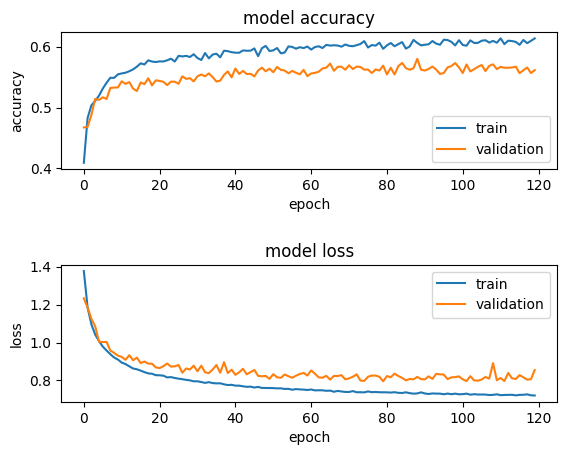

Final Test Accuracy: 0.5851616859436035


In [10]:
# Select the final model based on the average test accuracy across all folds
best_model_index = test_accuracy.index(max(test_accuracy))
best_model = models[best_model_index]
best_model_history = hist[best_model_index]
best_model_train_acc = train_accuracy[best_model_index]
best_model_train_loss = train_loss[best_model_index]
best_model_val_acc = val_accuracy[best_model_index]
best_model_val_loss = val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", test_accuracy[best_model_index])

433/433 [==============================] - 1s 2ms/step
Classification report:
               precision    recall  f1-score   support

           0       0.58      0.44      0.50      1909
           1       0.50      0.74      0.60      4575
           2       0.80      0.83      0.81      2787
           3       0.44      0.22      0.29      2469
           4       0.66      0.50      0.57      2066
           5       1.00      0.60      0.75        50

    accuracy                           0.59     13856
   macro avg       0.66      0.55      0.59     13856
weighted avg       0.59      0.59      0.57     13856



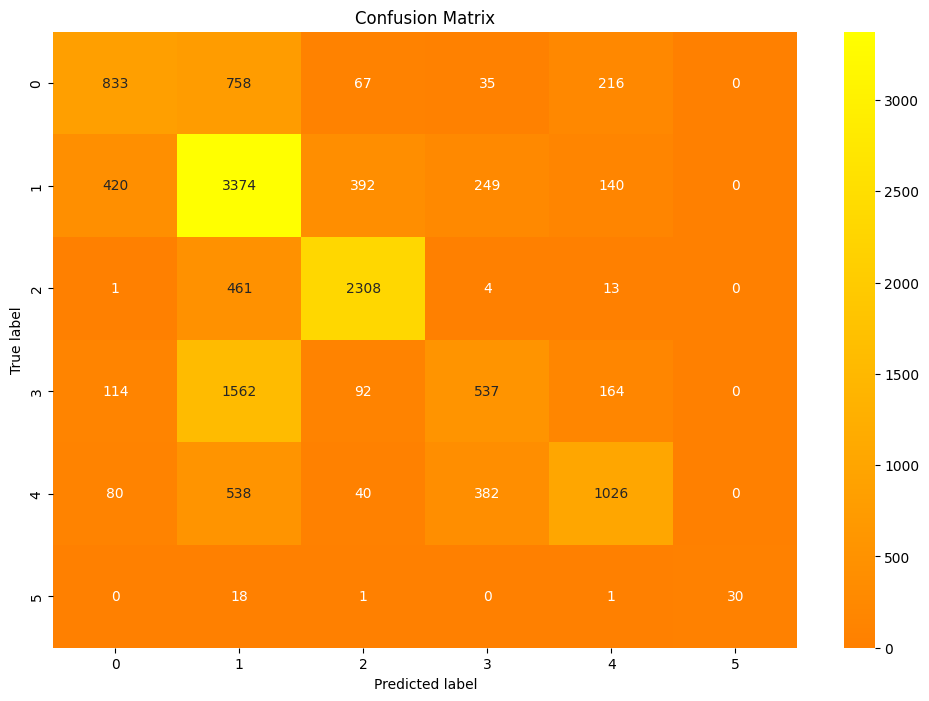

Confusion matrix:
 [[ 833  758   67   35  216    0]
 [ 420 3374  392  249  140    0]
 [   1  461 2308    4   13    0]
 [ 114 1562   92  537  164    0]
 [  80  538   40  382 1026    0]
 [   0   18    1    0    1   30]]
Accuracy: 0.585161662817552


In [11]:
# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label=np.argmax(y_pred, axis = 1)


rounded_ytestenc=np.argmax(y_test_enc, axis=1)

# Print the classification report
print("Classification report:\n", classification_report(rounded_ytestenc, y_pred_label))

cm = confusion_matrix(rounded_ytestenc, y_pred_label)
draw_confusion_matrix(cm)
print("Confusion matrix:\n", cm)

#Printing the accuracy
print("Accuracy:",accuracy(cm))


433/433 [==============================] - 1s 2ms/step


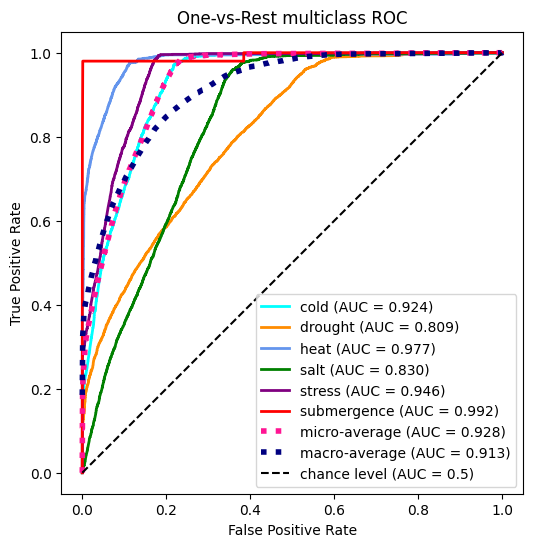

In [12]:

target_names = np.array(['cold', 'drought', 'heat', 'salt', 'stress', 'submergence'])

n_classes = len(np.unique(Y)) # 6

# predict probabilities for each class
y_score = best_model.predict(X_test)


# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()

# ROC curve using micro-averaged OvR
# Compute micro-average ROC curve and ROC area
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_enc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_enc.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#Plot all OvR ROC curves together
fig, ax = plt.subplots(figsize=(8, 6))

colors = cycle(["aqua", "darkorange", "cornflowerblue", "green", "purple", "red"])
for class_id, color, target_name in zip(range(n_classes), colors, target_names):
    plt.plot(
        fpr[class_id],
        tpr[class_id],
        color=color,
        lw=2,
        label=f"{target_name} (AUC = {roc_auc[class_id]:.3f})",
    )

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average (AUC = {roc_auc['micro']:.3f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average (AUC = {roc_auc['macro']:.3f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)



plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest multiclass ROC")
plt.legend(loc="lower right")
plt.show()

In [13]:
import pickle

filepath = 'MLP_roc.pkl'
data = {'MLP_fpr_macro': fpr['macro'],
        'MLP_tpr_macro': tpr['macro'],
        'MLP_auc_macro': roc_auc['macro']}

with open(filepath,'wb') as f:
    pickle.dump(data,f)

In [14]:
#created for the result.csv
dataTrait1 = df.drop(columns=["Class"]) #create for csv output
X1 = dataTrait1.drop(["Trait"], axis=1) #create for csv output

# split into train and test sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, Y, test_size=0.33, random_state=1)

# extract OsID from test data 
OsID_test = X_test1['OsID'].values

trait_names = (['cold', 'drought', 'heat', 'salt', 'stress', 'submergence'])

# map class labels to target names
true_class = [trait_names[i] for i in rounded_ytestenc]
predicted_class = [trait_names[i] for i in y_pred_label]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': true_class,
    'Predicted Class': predicted_class,
    'True/False': [x == y for x, y in zip(true_class, predicted_class)]})


# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_trait classification.csv', index=False)

           OsID True Class Predicted Class  True/False
0  Os09g0522200       cold         drought       False
1  Os11g0592200    drought         drought        True
2  Os01g0699100     stress            salt       False
3  Os02g0126400    drought         drought        True
4  Os03g0669100    drought         drought        True
